In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.sparse as sp

import time as time

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v2 import Autoencoder
from tools.ConvESN_v3 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-02-20 04:27:26.134960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 04:27:26.135538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 04:27:26.209767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 04:27:26.210158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 04:27:26.210403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-20 04:27:26.212169: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 04:27:26.212738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 04:27:26.213082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 04:27:26.213411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ConvESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '013'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ConvESN/ESN_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_008
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_013
data_dir_idx: 000
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
# all_data = all_data[]

In [15]:
delta_t = 1.
T = t_recorded_samples[-1]

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]

In [17]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (100001, 2, 50, 50)


In [18]:
all_data = all_data[0:int(all_data.shape[0]/3)]

In [19]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (33333, 2, 50, 50)


# Autoencoder

In [20]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [21]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1:], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

2023-02-20 04:27:32.446473: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [22]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
# num_latent_states = latent_states_all.shape[1]

temp_ = latent_states_all.reshape(latent_states_all.shape[0], -1)
time_stddev_AEproducedlatentstates = np.std(temp_, axis=0)

In [23]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [24]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.25
    num_input_tsteps = 500
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    res_channels = 100
    kernel_size = 5 # ae_net.kernel_size
    stateful = True
    omega_in = 1.0
    rho_res = 0.6
    usebias_Win = False
    alpha = 0.99
    ESN_cell_activations = 'tanh'
    usebias_Wout = True
    
    # saving simulation data
    sim_data = {
        'T':T,
        'delta_t':delta_t,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'delta_t':delta_t,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [25]:
og_ls_shape = latent_states_all.shape
latent_states_all = latent_states_all.reshape((latent_states_all.shape[0], -1))

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    [latent_states_all.shape[0]],#boundary_idx_arr,
    dt_rnn,#delta_t,
    #params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
print( 'data_rnn_input.shape : ', data_rnn_input.shape)
print('data_rnn_output.shape : ', data_rnn_output.shape)

data_rnn_input.shape :  (66, 500, 169)
data_rnn_output.shape :  (66, 500, 169)


In [28]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0) # time stddev of the rnn_data
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [29]:
data_rnn_input = data_rnn_input.reshape(data_rnn_input.shape[0:2]+og_ls_shape[1:])
data_rnn_output = data_rnn_output.reshape(data_rnn_output.shape[0:2]+og_ls_shape[1:])

In [30]:
print( 'data_rnn_input.shape : ', data_rnn_input.shape)
print('data_rnn_output.shape : ', data_rnn_output.shape)

data_rnn_input.shape :  (66, 500, 1, 13, 13)
data_rnn_output.shape :  (66, 500, 1, 13, 13)


In [31]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    epochs = 1
    lambda_reg = 1e-7 # weight for regularizer
    min_delta = 1e-6
    patience = 5
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 1
    fRMS = 0.5/100
    use_best = False

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'epochs':epochs,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'lambda_reg':lambda_reg,
        'min_delta':min_delta,
        'patience':patience,
        'use_best':use_best,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    epochs = tparams_dict['epochs']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    lambda_reg = tparams_dict['lambda_reg']
    min_delta = tparams_dict['min_delta']
    patience = tparams_dict['patience']
    try:
        use_best = tparams_dict['use_best']
    except:
        print("'use_best' not present in 'training_specific_params', set to True.")
        use_best = True

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [32]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [33]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_val]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [34]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (53, 500, 1, 13, 13)
 testing_data_rnn_input.shape :  (6, 500, 1, 13, 13)
     val_data_rnn_input.shape :  (7, 500, 1, 13, 13)


In [35]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    data_dim = training_data_rnn_input.shape[2:]


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        res_channels=res_channels,
        kernel_size=kernel_size,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(1,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33173722
stddev : 0.0016586861014366151
init Wres made : 6.0689473152160645 s.
Wres pp dealt with : 9.945160150527954 s.
sparse Wres made : 20.018823385238647 s.
spectral radius found : 65.88368225097656 s.


In [36]:
rnn_net.rnn_list[0].cell.og_spectral_rad_Wres
# rnn_net.rnn_list[0].cell.Wres.kernel#.numpy().max()

32.981834

In [37]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
# elif behaviour == 'loadCheckpointAndContinueTraining':
#     val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
#         dir_name_ae=dir_name_rnn,
#         dir_sep=dir_sep,
#         epochs=epochs,
#         learning_rate_list=learning_rate_list,
#         return_earlystopping_wait=True)
#     savelosses_cb_vallossarr = val_loss_arr_fromckpt
#     savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [38]:
training_data_rnn_input.dtype

dtype('float32')

In [39]:
def make_Umat_SUmatlst(
        kernel_size, input_channels,
        input_ylen, input_xlen,
        output_ylen, output_xlen,
        use_bias,
    ):
    
    ##### making the U matrix #####
    output_channels = 1

    U_shape_rows_0 = kernel_size*kernel_size*input_channels
    U_shape_cols_0 = input_channels*input_ylen*input_xlen

    U_shape_cols = U_shape_cols_0
    if use_bias == True:
        U_shape_rows_0 += 1
        U_shape_cols += 1

    U_shape_rows_1 = U_shape_rows_0*output_channels
    U_shape_rows = U_shape_rows_1*output_ylen*output_xlen*output_channels

    row_ind = []
    col_ind = []

    for l0 in range(output_channels):
        begin_row_l0 = l0*int(U_shape_rows/output_channels)
        for i0 in range(output_ylen):
            begin_row_i0 = begin_row_l0 + U_shape_rows_1*output_xlen*i0
            for i1 in range(output_xlen):
                begin_row_i1 = begin_row_i0 + U_shape_rows_1*i1
                begin_row_j0 = begin_row_i1 + U_shape_rows_0*l0
                for j1 in range(input_channels):
                    begin_row_j1 = begin_row_j0 + j1*kernel_size*kernel_size
                    begin_col_j1 = j1*input_xlen*input_ylen

                    for k0 in range(kernel_size):
                        begin_col_k0 = begin_col_j1 + i0*input_xlen + i1 + k0*input_xlen
                        for k1 in range(kernel_size):
                            row_ind.append(begin_row_j1+k0*kernel_size+k1)
                            col_ind.append(begin_col_k0+k1)
                if use_bias == True:
                    row_ind.append(begin_row_j0+input_channels*kernel_size*kernel_size)
                    col_ind.append(U_shape_cols-1)

    row_ind = np.array(row_ind)
    col_ind = np.array(col_ind)
    data = np.ones_like(row_ind)
    
    U_mat = sp.coo_array((data, (row_ind, col_ind)), shape=(U_shape_rows, U_shape_cols)).tocsr()
    
    ##### making the SU matrices #####
    SU_mat_lst = []
    SU_mat_rows = output_xlen*output_ylen*output_channels

    U_rows_to_index = np.arange(0, U_shape_rows, U_shape_rows_1)-1
    for i0 in range(U_shape_rows_1):
        # iter_time = time.time()
        U_rows_to_index += 1
        SU_mat_ind = []
        SU_mat_indptr = [0]
        elems_row_ind = 0
        for i1_iter in range(len(U_rows_to_index)):
            i1 = U_rows_to_index[i1_iter]
            row = U_mat.getrow(i1)
            row_ind = row.indices
            SU_mat_ind.extend(row_ind)
            SU_mat_indptr.append(len(SU_mat_ind))
            elems_row_ind += len(row_ind)
        SU_mat_ind = np.array(SU_mat_ind)
        SU_mat_indptr = np.array(SU_mat_indptr)
        SU_mat_data = np.ones_like(SU_mat_ind)
        SU_mat_lst.append(sp.csr_array(
            (SU_mat_data, SU_mat_ind, SU_mat_indptr),
            shape=(SU_mat_rows, U_shape_cols),
        ))
        # print('iter_time : {} s.'.format(time.time() - iter_time))

    return U_mat, SU_mat_lst

In [40]:
def print_s(s, filler='-', num_chars=80, above_filler=True, below_filler=True):
    s = int((num_chars - len(s))//2)*filler + s
    s = s + (num_chars-len(s))*filler
    if above_filler:
        print('\n\n' + filler*len(s))
    print('\n' + s+'\n')
    if below_filler:
        print(filler*len(s) + '\n\n')
    return

In [41]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    metrics=['mse'],
    run_eagerly=False
)

# training_data_rnn_input = training_data_rnn_input[0:3]
lambda_reg = float(lambda_reg)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    rnn_net.load_weights(wt_file)
    
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':

    Wout_kernels = 0
    if usebias_Wout == True:
        Wout_kernels_bias = 0
    val_mse_best = np.inf
    wait = 0
    
    channels_in_Wout = res_channels
    channels_out_Wout = data_dim[-3]
    output_ylen_Wout = data_dim[-2]
    output_xlen_Wout = data_dim[-1]
    input_ylen_Wout = output_ylen_Wout + kernel_size-1 # because res output is padded before feeding into Wout
    input_xlen_Wout = output_xlen_Wout + kernel_size-1 # because res output is padded before feeding into Wout

    kernel_elems_Wout = kernel_size*kernel_size*channels_in_Wout
    if usebias_Wout == True:
        kernel_elems_Wout += 1
    A_mat = np.zeros(shape=(kernel_elems_Wout, kernel_elems_Wout))
    B_vec = np.zeros(shape=(channels_out_Wout, kernel_elems_Wout))
  
    U_mat, SU_mat_lst = make_Umat_SUmatlst(
        kernel_size, channels_in_Wout,
        input_ylen_Wout, input_xlen_Wout,
        output_ylen_Wout, output_xlen_Wout,
        usebias_Wout
    )

    kernels = np.zeros(shape=(kernel_size, kernel_size, channels_in_Wout, channels_out_Wout))
    if usebias_Wout == True:
        kernels_bias = np.zeros(shape=channels_out_Wout)


    num_batches = training_data_rnn_input.shape[0]
    SU_x_lst = np.empty(shape=(kernel_elems_Wout, SU_mat_lst[0].shape[0], training_data_rnn_input.shape[1]))
    # SU_x_buffer = np.empty_like(SU_x_lst)
    
    for i in range(epochs):
        epoch_totaltime = time.time()
        print_s(' EPOCH : {} '.format(i+1))
        
        ##### computing Wout #####
        epoch_time = time.time()
        
        # computing the A matrix and the individual output channel B vectors
        A_mat_compute_time = time.time()
        A_mat[:, :] = 0.0
        B_vec[:, :] = 0.0
        BvecAmatj_time_mean = 0.0
        runs = training_data_rnn_input.shape[0]
        for j in range(runs):
            start_time = time.time()
            input_x = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=True))
            if len(input_x.shape) > 4:
                input_x = input_x[0]
            input_x = input_x.reshape(input_x.shape[0], -1)
            if usebias_Wout == True:
                input_x = np.concatenate(
                    (input_x, np.ones(shape=(input_x.shape[0], 1))),
                    axis=1
                )
            # SU_x_lst = []
            input_x = input_x.transpose()
            for i1 in range(kernel_elems_Wout):
                SUi1_x = SU_mat_lst[i1].dot(input_x)
                # SU_x_lst.append(SUi1_x)
                SU_x_lst[i1] = SUi1_x
                for i2 in range(i1):
                    SUi2_x = SU_x_lst[i2]
                    A_mat[i1, i2] += np.sum(SUi2_x*SUi1_x)
                A_mat[i1, i1] += np.sum(SUi1_x*SUi1_x)
            # for i1 in range(kernel_elems_Wout):
            #     SUi1_x = SU_mat_lst[i1].dot(input_x)
            #     SU_x_lst[i1] = SUi1_x
            #     A_mat[i1, 0:i1+1] += np.sum(
            #         SU_x_lst[0:i1+1]*SUi1_x,
            #         axis=(-2, -1)
            #     )
            Amatj_time = time.time()-start_time

            for l in range(channels_out_Wout):
                time_single_channel = time.time()
                output_y = training_data_rnn_output[j, :, l]
                output_y = output_y.reshape(output_y.shape[0], -1).transpose()
                for i1 in range(kernel_elems_Wout):
                    B_vec[l, i1] += np.sum(output_y*SU_x_lst[i1])
            BvecAmatj_time = time.time()-start_time
            BvecAmatj_time_mean = (j*BvecAmatj_time_mean+BvecAmatj_time)/(j+1)
            eta = BvecAmatj_time_mean*(runs-j-1)
            print('{}/{} A_mat j time : {:.4f} s.; A_mat and B_vec j time : {:.4f} s.; eta : {:.0f} h {:.0f} m {:.0f} s.'.format(
                j+1,
                runs,
                Amatj_time,
                BvecAmatj_time,
                int(eta // 3600),
                int( (eta % 3600) // 60),
                int(eta % 60),
            ))

        for i1 in range(kernel_elems_Wout):
            for i2 in range(i1+1, kernel_elems_Wout):
                A_mat[i1, i2] = A_mat[i2, i1]
        A_mat += lambda_reg*np.eye(A_mat.shape[0])
        A_inv = np.linalg.inv(A_mat)
        A_mat_compute_time = time.time() - A_mat_compute_time
        print_s('A_mat & B_vec computed, time taken : {:.4f} s.'.format(A_mat_compute_time), filler='', above_filler=False, below_filler=False)
        
        # computing the kernels
        for l in range(channels_out_Wout):
            time_single_channel = time.time()
            kernel_elems_l = A_inv @ B_vec[l].reshape(B_vec[l].shape[0], 1)
            if usebias_Wout == True:
                kernels_bias[l] = kernel_elems_l[-1]
                kernel_elems_l = kernel_elems_l[0:-1]
            kernel_elems_l = kernel_elems_l.reshape(channels_in_Wout, kernel_size, kernel_size)
            kernel_elems_l = np.transpose(kernel_elems_l, axes=(1, 2, 0))
            kernels[:, :, :, l] = kernel_elems_l
            print('time for out_channel {} : {:.4f} s'.format(l, time.time()-time_single_channel))
        
        print('\nepoch_time : {} sec'.format(time.time() - epoch_time))

        # averaging Wout
        Wout_kernels = Wout_kernels*i/(i+1) + kernels*1/(i+1)
        tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_kernels)
        if usebias_Wout == True:
            Wout_kernels_bias = Wout_kernels_bias*i/(i+1) + kernels_bias*1/(i+1)
            tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_kernels_bias)

        for layer in rnn_net.rnn_list:
            layer.reset_states()

        print('\nval mse')
        # '''
        val_mse = 0
        for j in range(val_data_rnn_input.shape[0]):
            batch_time = time.time()
            val_pred = np.array(rnn_net(val_data_rnn_input[j:j+1], training=False))
            temp = (val_pred - val_data_rnn_output[j:j+1])**2
            temp = temp.reshape(temp.shape[0], temp.shape[1], -1)
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            val_mse = val_mse*j/(j+1) + temp*1/(j+1)
            print('{} / {} -- batch_time : {} sec'.format(
                j+1,
                val_data_rnn_input.shape[0],
                time.time() - batch_time
            ))

        for layer in rnn_net.rnn_list:
            layer.reset_states()

        print('\ntraining mse')
        # '''
        train_mse = 0
        for j in range(training_data_rnn_input.shape[0]):
            batch_time = time.time()
            train_pred = np.array(rnn_net(training_data_rnn_input[j:j+1], training=False))
            temp = (train_pred - training_data_rnn_output[j:j+1])**2
            temp = temp.reshape(temp.shape[0], temp.shape[1], -1)
            temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
            temp = np.mean(temp, axis=-1)
            temp = np.mean(temp, axis=-1)
            train_mse = train_mse*j/(j+1) + temp*1/(j+1)
            print('{} / {} -- batch_time : {} sec'.format(
                j+1,
                training_data_rnn_input.shape[0],
                time.time() - batch_time
            ))
        
        for layer in rnn_net.rnn_list:
            layer.reset_states()

        val_loss_hist.append(val_mse)
        train_loss_hist.append(train_mse)
        
        # print('\ntest_mse : {}'.format(test_mse))
        print('\ntrain_mse : {}'.format(train_mse))
        print('val_mse : {}'.format(val_mse))
        if val_mse + min_delta <= val_mse_best:
            print('val_mse improved from {}'.format(val_mse_best))
            Wout_kernels_best = Wout_kernels
            if usebias_Wout == True:
                Wout_kernels_bias_best = Wout_kernels_bias
            val_mse_best = val_mse
            wait = 0
        else:
            wait += 1
            print('val_mse did not improve from {}, wait : {}'.format(val_mse_best, wait))

        print('\nTotal epoch computation time : {} sec'.format(time.time()-epoch_totaltime))
            
        if wait >= patience:
            print('\nearly stopping')
            break
        
if use_best == True:
    tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_kernels_best)
    if usebias_Wout == True:
        tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_kernels_bias_best)
print('\ntest mse')
test_mse = 0
for j in range(testing_data_rnn_input.shape[0]):
    print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
    test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
    temp = (test_pred - testing_data_rnn_output[j:j+1])**2
    temp = temp.reshape(temp.shape[0], temp.shape[1], -1)
    temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
    temp = np.mean(temp, axis=-1)
    temp = np.mean(temp, axis=-1)
    test_mse = test_mse*j/(j+1) + temp*1/(j+1)
print('test_mse : {}'.format(test_mse))

for layer in rnn_net.rnn_list:
    layer.reset_states()



--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1/53 A_mat j time : 509.4847 s.; A_mat and B_vec j time : 509.9456 s.; eta : 7 h 21 m 57 s.
2/53 A_mat j time : 501.9135 s.; A_mat and B_vec j time : 502.3738 s.; eta : 7 h 10 m 14 s.
3/53 A_mat j time : 502.6412 s.; A_mat and B_vec j time : 503.1045 s.; eta : 7 h 0 m 57 s.
4/53 A_mat j time : 506.0093 s.; A_mat and B_vec j time : 506.4640 s.; eta : 6 h 52 m 48 s.
5/53 A_mat j time : 504.3372 s.; A_mat and B_vec j time : 504.8395 s.; eta : 6 h 44 m 16 s.
6/53 A_mat j time : 500.0932 s.; A_mat and B_vec j time : 500.5490 s.; eta : 6 h 35 m 13 s.
7/53 A_mat j time : 503.1192 s.; A_mat and B_vec j time : 503.6086 s.; eta : 6 h 26 m 42 s.
8/53 A_mat j time : 499.6292 s.; A_mat and B_vec j time : 500.0817 s.; eta : 6 h 17 m 54 s.
9/53 A_mat j tim

2 / 6
3 / 6
4 / 6
5 / 6
6 / 6
test_mse : 0.00010851108042212823


In [42]:
row_i = 9
ind_i = U_mat.indptr[row_i]
ind_ip1 = U_mat.indptr[row_i+1]

U_mat.indices[ind_i:ind_ip1]

array([21], dtype=int32)

In [43]:
A_mat[:, :].diagonal(A_mat.shape[0]-1 -24)

array([  14492.59326345,   14492.59326345,   14492.59326345,
         14492.59326345,    7652.33482176,   14492.59326345,
         14492.59326345,   14492.59326345,   14492.59326345,
          7652.33482176,   14492.59326345,   14492.59326345,
         14492.59326345,   14492.59326345,    7652.33482176,
         14492.59326345,   14492.59326345,   14492.59326345,
         14492.59326345,    7652.33482176,   14492.59326345,
         14492.59326345,   14492.59326345,   14492.59326345,
       2589206.58118529])

In [44]:
rnn_net.rnn_list[0].cell.Win.kernel

<tf.Variable 'rnn/esn__cell/kernel:0' shape=(5, 5, 1, 100) dtype=float32, numpy=
array([[[[ 0.5479121 , -0.12224312,  0.71719587, ..., -0.8247002 ,
          -0.7639882 ,  0.92379534]],

        [[ 0.8171614 ,  0.39941427, -0.46826008, ...,  0.7491241 ,
          -0.60713065, -0.37935266]],

        [[ 0.5548097 ,  0.94365287,  0.00148237, ...,  0.60405177,
           0.5589551 ,  0.28496656]],

        [[ 0.5579927 , -0.7308956 ,  0.07213607, ..., -0.40928194,
          -0.08290384, -0.11537175]],

        [[-0.39614522,  0.8368838 ,  0.5625881 , ...,  0.25202495,
          -0.27868533,  0.02547849]]],


       [[[ 0.47341138,  0.77280575,  0.8421144 , ...,  0.26753956,
           0.9636119 ,  0.24071541]],

        [[-0.04498825,  0.5228651 ,  0.80665576, ...,  0.18148959,
           0.30687842, -0.4012334 ]],

        [[-0.5172559 , -0.3550153 , -0.6891169 , ..., -0.66902447,
           0.45036665,  0.41618246]],

        [[ 0.47716078, -0.36569366,  0.7800389 , ..., -0.5958238 ,
  

In [45]:
(kernels**2).mean()**0.5

0.004938886592520248

In [46]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
#     test_loss = rnn_net.evaluate(
#         testing_data_rnn_input, testing_data_rnn_output,
#     )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
#             'lr_change':lr_change,
            'test_loss':test_mse
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

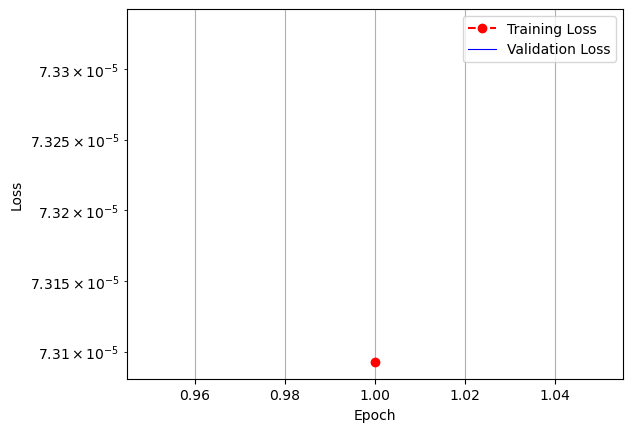

In [47]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=None,
    learning_rate_list=None,
    traininglossplot_kwargs={'marker':'o'}
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [48]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    # for i in range(data.shape[-1]):
    #     new_data[:, i] -= normalization_arr[0, i]
    #     new_data[:, i] /= normalization_arr[1, i]
    new_data -= normalization_arr[0]
    new_data *= normalization_arr[1]
    
    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    # for i in range(shape[-1]):
    #     if len(shape) == 2:
    #         new_data[:, i] *= normalization_arr[1, i]
    #         new_data[:, i] += normalization_arr[0, i]
    #     elif len(shape) == 3:
    #         new_data[:, :, i] *= normalization_arr[1, i]
    #         new_data[:, :, i] += normalization_arr[0, i]
    new_data *= normalization_arr[1]
    new_data += normalization_arr[0]
    return new_data

# Auto Regressive ESN

In [49]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

In [50]:
T_sample_input_AR = 1*(1/0.065) # np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*(1/0.065) # np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 860
data_.shape : (1, 677, 1, 13, 13)


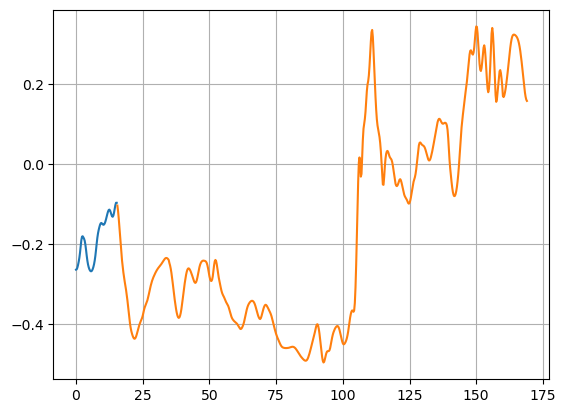

In [51]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0, 0, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0, 0, 0])
plt.grid(True)
plt.show()

In [52]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    layer.reset_states()
    
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :], training=False))[0]

prediction_lst.append(input_preds[-1])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array([[prediction_lst[-1]]])
    output = np.array(rnn_net(data_in_i, training=False))[0, 0]
    prediction_lst.append(output)

In [53]:
prediction_lst = np.stack(prediction_lst)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (62, 1, 13, 13)
prediction_lst.shape : (615, 1, 13, 13)


In [54]:
input_preds = input_preds.reshape(input_preds.shape[0], -1)
prediction_lst = prediction_lst.reshape(prediction_lst.shape[0], -1)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (62, 169)
prediction_lst.shape : (615, 169)


Only plotting the first 32 latent states because of memory constraints.
0.455


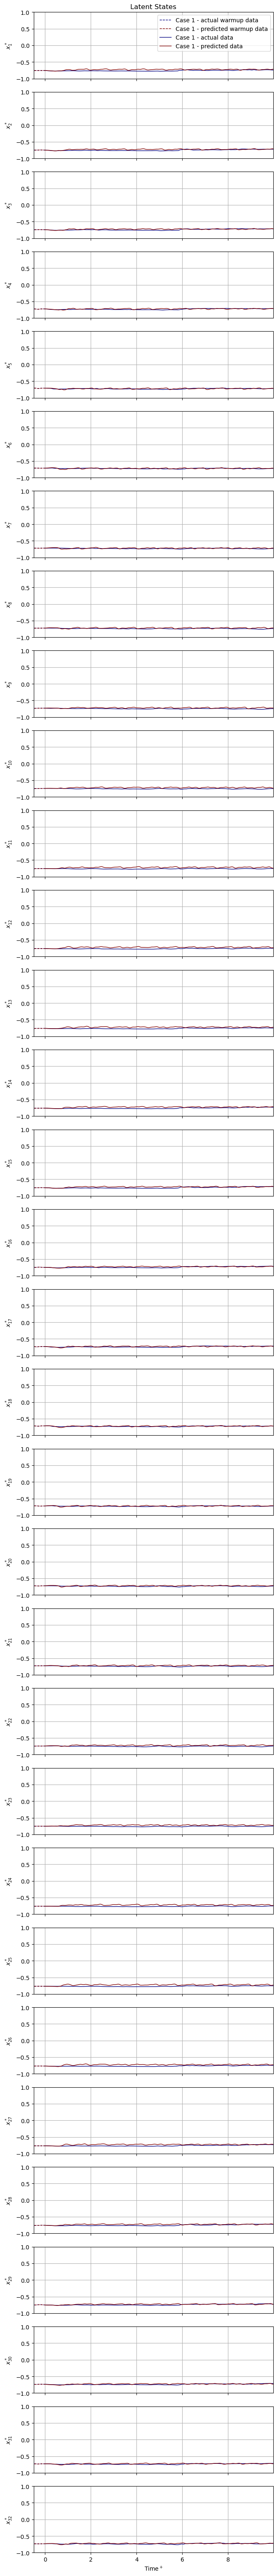

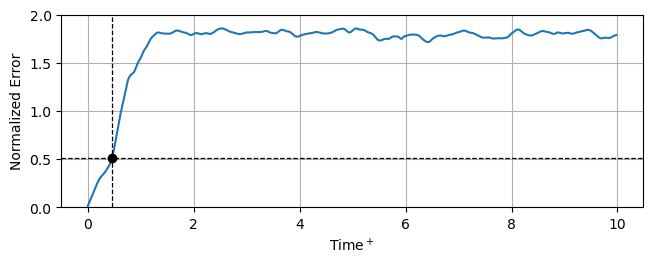

In [55]:
lyap_time = (1/0.065)# np.mean(lyapunov_time_arr)

n = 1
num_latent_states = 32#input_preds.shape[-1]# *input_preds.shape[-2]*input_preds.shape[-3]
N = num_sample_output_AR#num_output_timesteps

if num_latent_states != input_preds.shape[-1]:
    print('Only plotting the first {} latent states because of memory constraints.'.format(num_latent_states))

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

temp_ = data_[0, 0:num_sample_input_AR+N]
temp_ = temp_.reshape(temp_.shape[0], -1)
temp_ = invert_normalization(temp_, normalization_arr)
prediction_lst = invert_normalization(prediction_lst, normalization_arr)
input_preds = invert_normalization(input_preds, normalization_arr)
for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, temp_[:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, temp_[num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(rnn_data_boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (temp_[num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev_AEproducedlatentstates**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [56]:
try:
    if use_weights_post_dense == True:
        print(rnn_net.postWout.individual_weights)
except:
    pass

### Prediction horizon computation

In [57]:
def plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir,
    savefig_fname='pre_ARtraining',
    bin_width=0.05,
    bin_begin=0.0):
    
    fig, ax = plt.subplots()

    ph_mean = np.mean(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    
    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = int(np.round(bin_end/bin_width))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
    ax.axvline(ph_mean, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)')
    ax.set_ylabel('PDF')

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top'
    )

    ax.set_title('nbins = {}'.format(nbins))
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [58]:
normalization_arr.shape, time_stddev.shape

((2, 169), (169,))

In [59]:
num_runs = 100
num_runs = np.min([num_runs, maxpossible_num_runs])
print('num_runs : {}'.format(num_runs))

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

savefig_fname = 'pre_ARtraining-'+data_to_consider+'data'
npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])

prediction_horizon_arr = np.empty(shape=num_runs)

for i in range(num_runs):
    data_idx = data_idx_arr[i]

    # for j in range(len(rnn_data_boundary_idx_arr)):
    #     if data_idx < rnn_data_boundary_idx_arr[j]:
    #         case_idx = j
    #         break
    lyap_time = (1/0.065)#lyapunov_time_arr[0]

    ### picking the data
    data_ = data_in[0:1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]

    ### doing the predictions
    prediction_lst = []

    for layer in rnn_net.rnn_list:
        layer.reset_states()

    input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :], training=False))[0]

    prediction_lst.append(input_preds[-1])

    for j in range(1, num_sample_output_AR):
        data_in_j = np.array([[prediction_lst[-1]]])
        output = np.array(rnn_net(data_in_j, training=False))[0, 0]
        prediction_lst.append(output)
    prediction_lst = np.stack(prediction_lst)
    prediction_lst = prediction_lst.reshape(prediction_lst.shape[0], -1)
    prediction_lst = invert_normalization(prediction_lst, normalization_arr) # don't invert if using time_stddev in error
    
    data_out = data_[0, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR]
    data_out = data_out.reshape(data_out.shape[0], -1)
    data_out = invert_normalization(data_out, normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out[:, :] - prediction_lst[:, :])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev_AEproducedlatentstates**2), axis=1)**0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'error_threshold = {}\n'.format(error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname
)

npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))

num_runs : 100
saved_ConvESN/ESN_008

error_threshold = 0.5
prediction_horizon : 0.371475, median : 0.39
ph_min : 0.065, ph_max : 0.8450000000000001
stddev : 0.15891835364425344, IQR : 0.195
1st quartile : 0.26, 3rd quartile : 0.455
analysis time : 159.52982926368713 s



In [60]:
print('num_runs : {}'.format(num_runs))

num_runs : 100


In [61]:
prediction_horizon_arr

array([0.065  , 0.065  , 0.08125, 0.08125, 0.0975 , 0.0975 , 0.13   ,
       0.13   , 0.14625, 0.14625, 0.14625, 0.1625 , 0.1625 , 0.17875,
       0.195  , 0.195  , 0.195  , 0.195  , 0.21125, 0.21125, 0.2275 ,
       0.2275 , 0.26   , 0.26   , 0.26   , 0.27625, 0.27625, 0.2925 ,
       0.2925 , 0.2925 , 0.30875, 0.30875, 0.325  , 0.325  , 0.325  ,
       0.34125, 0.34125, 0.34125, 0.34125, 0.34125, 0.34125, 0.34125,
       0.34125, 0.3575 , 0.3575 , 0.3575 , 0.3575 , 0.39   , 0.39   ,
       0.39   , 0.39   , 0.39   , 0.39   , 0.39   , 0.39   , 0.39   ,
       0.39   , 0.39   , 0.40625, 0.40625, 0.40625, 0.40625, 0.40625,
       0.4225 , 0.4225 , 0.43875, 0.43875, 0.43875, 0.43875, 0.43875,
       0.43875, 0.43875, 0.455  , 0.455  , 0.455  , 0.455  , 0.455  ,
       0.455  , 0.47125, 0.47125, 0.4875 , 0.4875 , 0.4875 , 0.4875 ,
       0.4875 , 0.52   , 0.52   , 0.53625, 0.53625, 0.585  , 0.60125,
       0.6175 , 0.63375, 0.65   , 0.66625, 0.66625, 0.66625, 0.715  ,
       0.73125, 0.84

In [62]:
data_out.shape

(615, 169)